# One-hot text classification & CNN - combined classification

The steps we gotta do are:
1. Make a combined dataset (image links, not RecordIO TO START)
1. Make the combined NN
1. Train
1. Profit

In [1]:
# for nice plots
#!conda install -c anaconda pydot --yes
#!conda install -c anaconda graphviz --yes

In [2]:
import numpy as np

import tensorflow as tf

#!pip install -q tensorflow-hub
#!pip install -q tfds-nightly
import tensorflow_hub as hub
#import tensorflow_datasets as tfds

#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")


from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from functools import partial # for allowing inputs to functions
from PIL import Image


# for classifications
from glob import glob
import pickle
import csv
# splits
from sys import path
path.append('/Users/jillnaiman/scienceDigitization/')
from classification_utils import train_test_valid_split, pre_process_corpus
from contractions import CONTRACTION_MAP
from bs4 import BeautifulSoup
import unicodedata
import re
import sys

# for cleaning text
import nltk
# you need to do these downloads first
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('words')
from nltk.corpus import stopwords, words
import string
import itertools
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# a few bugs arise
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # for dying kernel... non-ideal

# too many messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

Version:  2.0.0
Eager mode:  True
Hub version:  0.9.0
GPU is NOT AVAILABLE


Import all data: the text and the classifications:

In [3]:
# where are square-found and OCR'd images stored:
wsFiles = ['/Users/jillnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/fig_caption_data/oldRuns/captions_and_squares_singleOrMulti_test5000_RS_trialNum_1.pickle', # with single/multi tags
           '/Users/jillnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/fig_caption_data/oldRuns/captions_and_squares_singleOrMulti_test5000_RS_trialNum_2.pickle']

# where are saved classifications stored -- these are the classified images that will be input into the CNN & we will associate them with their captions.
classDir_main_to = '/Users/jillnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/classifications/class_photos_ocr_tmp/' # _tmp is 224x224 gray scales from `classify_with_ocr.ipynb` by hand

# where models are gonna be saved to:
modelsDir = '/Users/jillnaiman/tmpModels/'

Read in all the image file names and their captions:

In [4]:
wsIn = []; full_run_caption_textIn = []; full_run_titleText = []; full_run_xaxisText = []; full_run_yaxisText = []; full_run_squares = []

for wsFile in wsFiles:
    with open(wsFile, 'rb') as f:
        wsIn1, full_run_squares1,_, _, full_run_caption_textIn1, _, full_run_titleText1, _, full_run_xaxisText1, full_run_yaxisText1, _  = pickle.load(f)
    # append
    for w, c, t, x, y in zip(wsIn1, full_run_caption_textIn1, full_run_titleText1, full_run_xaxisText1, full_run_yaxisText1):
        wsIn.append(w); full_run_caption_textIn.append(c); full_run_titleText.append(t); full_run_xaxisText.append(x); full_run_yaxisText.append(y)
    full_run_squares.extend(full_run_squares1)


In [5]:
ws = [w.split('/')[-1] for w in wsIn]
#len(ws)

Grab all the names of the classes:

In [6]:
newClasses = [log for log in glob(classDir_main_to + '/*')]
nctmp = []
for w in newClasses:
    if w.find('.csv') == -1:
        nctmp.append(w)
newClasses = nctmp
newClasses

['/Users/jillnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/classifications/class_photos_ocr_tmp/Sun',
 '/Users/jillnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/classifications/class_photos_ocr_tmp/Multifig',
 '/Users/jillnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/classifications/class_photos_ocr_tmp/RADEC',
 '/Users/jillnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/classifications/class_photos_ocr_tmp/Spectra',
 '/Users/jillnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/classifications/class_photos_ocr_tmp/RADECrel',
 '/Users/jillnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/classifications/class_photos_ocr_tmp/Illustrations',
 '/Users/jillnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/classifications/class_photos_ocr_tmp/Graph',
 '/Users/jillnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/classifications/class_photos_ocr_tmp/Simulations',
 '/Users/jillnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/classifications/c

Count number of files:

In [7]:
numImages = 0
for nc in newClasses:
    imgc = glob(nc + '/*')
    numImages += len(imgc)
print('Number of total classified images = ' + str(numImages))

Number of total classified images = 3336


## Generate Text Data

This is for re-processing the data and saving the text as a csv file for later use.  Shouldn't have to run too often unless you mess things up again :D

This process is now down "on the fly" with hand-classified images in `classify_with_ocr.ipynb`.

For each class we will go through and associate a caption & axis stuff to them:

In [8]:
make_csv = False # set to false if you don't wanna re-run this whole thing
use_surrounding_text = True # include title, x/yaxis text

logNum = 100
num = 0
if make_csv:
    captions = []
    classifications = []
    titles = []
    xaxis = []
    yaxis = []
    save_fname = []
    

    for c in newClasses:
        print('----- ' + c.split('/')[-1] + ' -------')
        fGroup = np.array([log.split('/')[-1].split('_s') for log in glob(c + '/*')]) # names of files
        fnames = fGroup[:,0]
        snum = [int(s.split('.')[0]) for s in fGroup[:,1]]
        # find in ws
        inds = np.arange(len(ws))
        for f,s in zip(fnames.tolist(),snum):
            save_fname.append(f+ '_s' + str(s).zfill(2))

            if num%logNum == 0:
                print('On ' + str(num) + ' of ' + str(numImages))
            num += 1 # update count of where we are
            
            mask = np.char.find(ws, f)
            i = inds[mask!=-1]
            haveCap = False
            capOut = ''
            titleOut = ''
            xlabOut = ''
            ylabOut = ''
            if len(i) > 0:
                # Grab captions & surrounding text
                cap = np.array(full_run_caption_textIn)[i[0]] # grab all captions for this image
                tit = np.array(full_run_titleText)[i[0]]
                xlab = np.array(full_run_xaxisText)[i[0]]
                ylab = np.array(full_run_yaxisText)[i[0]]
                # for this square of interest
                if len(cap) > 0:
                    cap = cap[s]
                    # for some reason.... this might cause an issues
                    if len(cap) == 0:
                        print('ERROR FOR: ' + f)
                        capOut = ''
                    else:
                        # put into a full caption
                        capOut = " ".join(np.array(cap)[:,1].tolist())
                        #captions.append(cap)
                        #classifications.append(c.split('/')[-1])
                        #save_fname.append(f)
                        haveCap = True
                else:
                    print("ERROR, no cap, for: " + f)
                    capOut = ''
                    
                if use_surrounding_text:
                    if len(tit) > 0:
                        tit = tit[s]
                        # for some reason.... this might cause an issues
                        if len(tit) == 0:
                            #print('ERROR FOR: ' + f + ' - title')
                            tit = ''
                        else:
                            # put into a full caption
                            tit = " ".join(np.array(tit)[:,1].tolist())
                            #titles.append(tit)
                            titleOut = tit
                    #else:
                    #    print("ERROR, no titile, for: " + f)
                        
                    if len(xlab) > 0:
                        xlab = xlab[s]
                        if len(xlab) == 0:
                            #print('ERROR FOR: ' + f + ' - xlabel')
                            xlab = ''
                        else:
                            # put into a full caption
                            xlab = " ".join(np.array(xlab)[:,1].tolist())
                            #xaxis.append(xlab)
                            xlabOut = xlab
                    #else:
                    #    print("ERROR, no xlabel, for: " + f)
                
                    if len(ylab) > 0:
                        ylab = ylab[s]
                        if len(ylab) == 0:
                            #print('ERROR FOR: ' + f + ' - ylabel')
                            ylab = ''
                        else:
                            # put into a full caption
                            ylab = " ".join(np.array(ylab)[:,1].tolist())
                            #yaxis.append(ylab)
                            ylabOut = ylab
                    #else:
                    #    print("ERROR, no xlabel, for: " + f)
                        
            titles.append(titleOut); xaxis.append(xlabOut); yaxis.append(ylabOut)
            captions.append(capOut); classifications.append(c.split('/')[-1])

In [9]:
print('all done!')

all done!


Put together into a csv file:

In [10]:
c1 = "/".join(classDir_main_to.split('/')[:-1]) + classDir_main_to.split('/')[-1]

if not use_surrounding_text:
    csvFileOut = c1 + '_text_classifications.csv'
else:
    csvFileOut = c1 + '_text_classifications_surroundText.csv'
    
csvFileOut

'/Users/jillnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/classifications/class_photos_ocr_tmp_text_classifications_surroundText.csv'

In [11]:
if make_csv:
    if not use_surrounding_text:
        with open(csvFileOut, 'w') as csvFile:
            writer = csv.writer(csvFile, quoting=csv.QUOTE_ALL)
            row = ['caption', 'class'] # header
            writer.writerow(row)
            for cap, cla in zip(captions, classifications):
                row = [str(cap), str(cla)]
                writer.writerow(row)
        csvFile.close()
    else:
        with open(csvFileOut, 'w') as csvFile:
            writer = csv.writer(csvFile, quoting=csv.QUOTE_ALL)
            row = ['caption', 'class', 'title', 'xlabel', 'ylabel', 'fname'] # header
            writer.writerow(row)
            for cap, cla,tit,xlab,ylab,fname in zip(captions, classifications,titles,xaxis,yaxis, save_fname):
                row = [str(cap), str(cla), str(tit), str(xlab), str(ylab), str(fname)]
                writer.writerow(row)
        csvFile.close()
        

dataset = pd.read_csv(csvFileOut)
# fill NAs with empty string
dataset = dataset.fillna(' ')

In [12]:
dataset.head()

,caption,class,title,xlabel,ylabel,fname
0,"Fig. 12—Same as Fig. 12, but for the September...",Sun,,,,a6f140f5-0583-48a8-a346-ad1666f54470_s00
1,,Sun,,,,8ed40b02-eeff-4426-9467-85aa7fc95890_s00
2,Fig. 6.—C 1v spectroheliogram and line profile...,Sun,,,,c0e2de31-d8a2-4fa0-ac05-f15750fea2c2_s00
3,,Sun,,,,30ae38f0-dc5a-41ee-b837-8140061a427e_s00
4,Fig. la Fig. 1.—{a) Part of the continuum imag...,Sun,,,,61ec9a54-07b9-43df-8f66-bb7620883f56_s00


In [13]:
#dataset['ylabel'][dataset['ylabel'].notnull()][0:100]
len(dataset)

3336

Let's make sure we don't do any double counting of entries:

In [14]:
du = dataset.drop_duplicates()
# replace with dropped dups
dataset = du
del du
len(dataset)

3336

Create an array of text labels for each class:

In [15]:
classes = []
for c in newClasses:
    classes.append(c.split('/')[-1])
    
classes = np.array(classes)
classes

array(['Sun', 'Multifig', 'RADEC', 'Spectra', 'RADECrel', 'Illustrations',
       'Graph', 'Simulations', 'Planets', 'SkyNoCoords', 'Photos'],
      dtype='<U13')

Associate these labels with numbers for classification ease:

In [16]:
labels = np.arange(len(classes))
dataset['labels'] = np.zeros(len(dataset)).astype('int')

labelsOut = []

for i in range(len(dataset)):
    #dataset.iloc[i]['labels'] = labels[classes == dataset.iloc[i]['class']][0]
    labelsOut.append(labels[classes == dataset.iloc[i]['class']][0])
    if len(labels[classes == dataset.iloc[i]['class']]) > 1:
        import sys
        sys.exit()
        
# set
dataset['labels'] = labelsOut

In [17]:
dataset.head()

,caption,class,title,xlabel,ylabel,fname,labels
0,"Fig. 12—Same as Fig. 12, but for the September...",Sun,,,,a6f140f5-0583-48a8-a346-ad1666f54470_s00,0
1,,Sun,,,,8ed40b02-eeff-4426-9467-85aa7fc95890_s00,0
2,Fig. 6.—C 1v spectroheliogram and line profile...,Sun,,,,c0e2de31-d8a2-4fa0-ac05-f15750fea2c2_s00,0
3,,Sun,,,,30ae38f0-dc5a-41ee-b837-8140061a427e_s00,0
4,Fig. la Fig. 1.—{a) Part of the continuum imag...,Sun,,,,61ec9a54-07b9-43df-8f66-bb7620883f56_s00,0


If requested, let's even out the number of items in each class:

In [18]:
limit_class_num = False # set to True if you want to limit the number of instances in each class
limit_num = 300 # how many examples per one class

if limit_class_num:
    dataset_new = pd.DataFrame(columns=dataset.columns)
    for c in newClasses:
        dsub = dataset[:][dataset['class']==c.split('/')[-1]]
        if len(dsub) > limit_num: # then subset
            inds = np.random.choice(range(len(dsub)-1),limit_num,replace=False)
        else:
            inds = np.arange(len(dsub)).astype('int')
        dataset_new = pd.concat([dataset_new,dsub.iloc[inds]])
    dataset = dataset_new
    del dataset_new


Process the captions et. al into a cleaned string of text:

In [19]:
if not use_surrounding_text:
    processed_captions = pre_process_corpus(dataset['caption'].values)
else:
    processed_captions = []
    cap = pre_process_corpus(dataset['caption'].values)
    tit = pre_process_corpus(dataset['title'].values)
    xlab = pre_process_corpus(dataset['xlabel'].values)
    ylab = pre_process_corpus(dataset['ylabel'].values)
    for c,t,x,y in zip(cap,tit, xlab,ylab):
        processed_captions.append( c + ' ' + t + ' ' + ' ' + x + ' ' + y)

Take out stop words and words like "fig" that we know are not helpful for 1-hot classification:

In [20]:
stop_words =set(stopwords.words('english'))

stop_words.add('TM')
stop_words.add('also')
stop_words.add('andor')

for i in range(len(processed_captions)):
    tmp = processed_captions[i].replace('fig','')
    words = tmp.split()
    wordsout = []
    for w in words:
        if len(w) > 1:
            if w.lower() not in stop_words:
                if w not in stop_words:
                    wordsout.append(w)
    tmp = " ".join(wordsout)
    processed_captions[i] = tmp

Count words and format for 1-hot:

In [21]:
words = []
for p in processed_captions:
    ww = p.split()
    for w in ww:
        words.append(w)
        
totalWords = np.unique(words)
datasetOneHot = dataset.copy()
for w in totalWords:
    datasetOneHot['word:'+w] = 0
    
print('We have ', len(totalWords), ' unique words in this dataset.')

We have  6684  unique words in this dataset.


Create the dataset with words counted as features:

In [22]:
# add the word or just one-hot?
oneHot = False
read_saved = True

c1 = "/".join(classDir_main_to.split('/')[:-1]) + classDir_main_to.split('/')[-1]
csvFileOut = c1 + '_saveDataFrame.csv'

if not read_saved:
    for i,p in enumerate(processed_captions):
        #wordCount[:] = 0
        for w in p.split():
            index = totalWords.tolist().index(w)+len(dataset.columns) if w in totalWords.tolist() else -1
            if index != -1:
                if not oneHot:
                    datasetOneHot.iloc[i,index] += 1
                else:
                    datasetOneHot.iloc[i,index] = 1
                    
    datasetOneHot.to_csv(csvFileOut)
else:
    datasetOneHot = pd.read_csv(csvFileOut)

In [23]:
for c in datasetOneHot.columns:
    if 'Unnamed:' in c:
        datasetOneHot = datasetOneHot.drop(columns=c)

In [24]:
datasetOneHot.head()

,caption,class,title,xlabel,ylabel,fname,labels,word:TMo,word:TMq,word:TMs,...,word:zoxadzht,word:zro,word:zs,word:zv,word:zvectors,word:zw,word:zwicky,word:zz,word:zzoarpromo,word:zzoarromo
0,"Fig. 12—Same as Fig. 12, but for the September...",Sun,,,,a6f140f5-0583-48a8-a346-ad1666f54470_s00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,,Sun,,,,8ed40b02-eeff-4426-9467-85aa7fc95890_s00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fig. 6.—C 1v spectroheliogram and line profile...,Sun,,,,c0e2de31-d8a2-4fa0-ac05-f15750fea2c2_s00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,,Sun,,,,30ae38f0-dc5a-41ee-b837-8140061a427e_s00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Fig. la Fig. 1.—{a) Part of the continuum imag...,Sun,,,,61ec9a54-07b9-43df-8f66-bb7620883f56_s00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train/Validation/Test Splits

Now we'll use our typical splits to make our own training splits to account for the fact that we have (possibly) different numbers of images in each category.  We'll do this by grabbing indicies to pull from the dataframe we just generated.

In [25]:
# percentage breakdown
train_per = 0.75
valid_per = 0.15
test_per = 0.10

if (train_per+valid_per+test_per) != 1.0:
    print('WHOA!  Not 100%!!')
    sys.exit()

In [26]:
X_full = np.arange(len(datasetOneHot))
Y_full = datasetOneHot['labels'].values

# own splits
train_ind, _, valid_ind, _, test_ind, _ = train_test_valid_split(X_full, Y_full, 
                                                                 train_size = train_per, valid_size = valid_per, test_size = test_per, 
                                                                 textClassification=True, asInts=False)

print('We have', len(train_ind), 'training,', len(valid_ind), 'validation,', len(test_ind), 'test instances.')

We have 2502 training, 502 validation, 332 test instances.


Grab the text data as split:

In [27]:
X_train_text = datasetOneHot.iloc[train_ind,len(dataset.columns)-2:]#.values 
X_valid_text = datasetOneHot.iloc[valid_ind,len(dataset.columns)-2:]#.values 
X_test_text = datasetOneHot.iloc[test_ind,len(dataset.columns)-2:]#.values 

In [28]:
X_train_text.head()

,fname,labels,word:TMo,word:TMq,word:TMs,word:aTM,word:aa,word:aaa,word:aadtr,word:aal,...,word:zoxadzht,word:zro,word:zs,word:zv,word:zvectors,word:zw,word:zwicky,word:zz,word:zzoarpromo,word:zzoarromo
684,79e36b8c-30af-4381-b14c-927c8e40c192_s00,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2590,aa031ba5-1465-4c90-9ca3-5e01eed9cf6d_s00,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
438,85f5a2f1-c02c-4925-84e1-3b415d0d3a5e_s01,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1346,c117d0c2-9e0a-4264-b99e-e49b5443fda3_s01,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2305,2ad79ec8-5ec7-4c16-8133-15a42ac95af4_s00,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


To make a generator that will loop through all data, we need to save this info as a csv and then read it back in a line at a time in our generator.

This is following with: https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

In [29]:
X_train_text.to_csv(modelsDir + 'train.csv', index=False, header=False)
X_valid_text.to_csv(modelsDir + 'validation.csv', index=False, header=False)
X_test_text.to_csv(modelsDir + 'test.csv', index=False, header=False)

Make a Python generator to upload & process our data.  I've also included a tester function to try it out:

In [30]:
# let's try making out own generator ... I *think* this is inefficient however!
def generate_data(split, classDir = '', classes='', batch_size=32, img_resize=[224,224], 
                  net='VGG16', modDir='/Users/jillnaiman/tmpModels/'):
    ftrain = open(modDir+'train.csv','r')
    fvalid = open(modDir+'validation.csv','r')
    ftest = open(modDir+'test.csv','r')
    while True:
        
        labels = []; imgs = []; oneHots = []
    
        while len(imgs) < batch_size:
            if 'train' in split:
                line = ftrain.readline()
                if line == "": # if EOF => loop back to start
                    ftrain.seek(0)
                    line = ftrain.readline()
            elif 'valid' in split:
                line = fvalid.readline()
                if line == "": # if EOF => loop back to start
                    fvalid.seek(0)
                    line = fvalid.readline()
            elif 'test' in split:
                line = ftest.readline()
                if line == "": # if EOF => loop back to start
                    ftest.seek(0)
                    line = ftest.readline()
                    # make sure if we are evaluating with the test set 
                    #  we don't loop back to the start of the file
                    break 
            else:
                print('NOPE!')
                sys.exit()

            # break file into parts as stored
            line = line.strip().split(",")
            
            label = np.int64(line[1]) # label is 2nd column
            
            #label = X.iloc[ind]['labels']
            # file name is stored in 1st entry
            file_path = classDir + '/' + classes[label] + '/' + line[0] + '.jpeg'

            img = np.array(Image.open(file_path))

            # rest are one-hots
            #oneHot = X.iloc[ind][X.columns[2:]].values ###.reshape(len(X_train_text),len(totalWords),1)
            oneHot = np.array(line[2:]).astype('int64')
            
            # format for the oneHot
            labels.append(label); imgs.append(img); oneHots.append(oneHot)

        label = tf.cast(np.array(labels), tf.int64); img = tf.cast(np.array(imgs)[...,np.newaxis], tf.float32)
        oneHot = tf.cast(np.array(oneHots,dtype=np.float)[...,np.newaxis], tf.float32) # note special casting for oneHot -> its from pandas

        yield [img, oneHot], label
        

# for testing:
def generate_data_test_old(split, classDir = '', classes='', batch_size=32, img_resize=[224,224], net='VGG16'):
    if 'train' in split:
        X = X_train_text
    elif 'valid' in split:
        X = X_valid_text
    elif 'test' in split:
        X = X_test_text
    else:
        print('NOPE!')
        sys.exit()

    inds = np.random.choice(range(len(X)-1),batch_size,replace=False)  
#     X_full = np.arange(len(X))
#     Y_full = X['labels'].values
#     train_per = batch_size/len(X)
#     # these are not used
#     valid_per = 0.1
#     test_per = 1.0 - train_per - valid_per
#     #print(train_per, valid_per, test_per, train_per+valid_per+test_per)
#     # own splits
#     inds, _, _, _, _, _ = train_test_valid_split(X_full, Y_full, 
#                                                 train_size = train_per, valid_size = valid_per, test_size = test_per, 
#                                                 textClassification=True, asInts=False)

    labels = []; imgs = []; oneHots = []
    for ind in inds:
        label = X.iloc[ind]['labels']
        #print(type(label))
        file_path = classDir + '/' + classes[label] + '/' + X.iloc[ind]['fname'] + '.jpeg'

        img = np.array(Image.open(file_path))

        oneHot = X.iloc[ind][X.columns[2:]].values ###.reshape(len(X_train_text),len(totalWords),1)
        #print(type(oneHot))
        #sys.exit()

        # format for the oneHot
        labels.append(label); imgs.append(img); oneHots.append(oneHot)

    label = tf.cast(np.array(labels), tf.int64); img = tf.cast(np.array(imgs)[...,np.newaxis], tf.float32)
    oneHot = tf.cast(np.array(oneHots,dtype=np.float)[...,np.newaxis], tf.float32)

    return [img, oneHot], label

# let's try making out own generator ... I *think* this is inefficient however!
def generate_data_old(split, classDir = '', classes='', batch_size=32, img_resize=[224,224], net='VGG16'):
    while True:
        if 'train' in split:
            X = X_train_text
        elif 'valid' in split:
            X = X_valid_text
        elif 'test' in split:
            X = X_test_text
        else:
            print('NOPE!')
            sys.exit()


        inds = np.random.choice(range(len(X)-1),batch_size,replace=False)  

        labels = []; imgs = []; oneHots = []
        for ind in inds:
            label = X.iloc[ind]['labels']
            file_path = classDir + '/' + classes[label] + '/' + X.iloc[ind]['fname'] + '.jpeg'

            img = np.array(Image.open(file_path))

            oneHot = X.iloc[ind][X.columns[2:]].values ###.reshape(len(X_train_text),len(totalWords),1)

            # format for the oneHot
            labels.append(label); imgs.append(img); oneHots.append(oneHot)

        label = tf.cast(np.array(labels), tf.int64); img = tf.cast(np.array(imgs)[...,np.newaxis], tf.float32)
        oneHot = tf.cast(np.array(oneHots,dtype=np.float)[...,np.newaxis], tf.float32) # note special casting for oneHot -> its from pandas

        yield [img, oneHot], label

def generate_data_test(split, classDir = '', classes='', batch_size=32, img_resize=[224,224], 
                  net='VGG16', modDir='/Users/jillnaiman/tmpModels/'):
    ftrain = open(modDir+'train.csv','r')
    fvalid = open(modDir+'validation.csv','r')
    ftest = open(modDir+'test.csv','r')
    if True:
        
        labels = []; imgs = []; oneHots = []
    
        while len(imgs) < batch_size:
            if 'train' in split:
                line = ftrain.readline()
                if line == "": # if EOF => loop back to start
                    ftrain.seek(0)
                    line = ftrain.readline()
            elif 'valid' in split:
                line = fvalid.readline()
                if line == "": # if EOF => loop back to start
                    fvalid.seek(0)
                    line = fvalid.readline()
            elif 'test' in split:
                line = ftest.readline()
                if line == "": # if EOF => loop back to start
                    ftest.seek(0)
                    line = ftest.readline()
                    # make sure if we are evaluating with the test set 
                    #  we don't loop back to the start of the file
                    break 
            else:
                print('NOPE!')
                sys.exit()

            # break file into parts as stored
            line = line.strip().split(",")
                        
            label = np.int64(line[1]) # label is 2nd column
            #print(type(label))
            #print(label)
            
            #label = X.iloc[ind]['labels']
            # file name is stored in 1st entry
            file_path = classDir + '/' + classes[label] + '/' + line[0] + '.jpeg'

            img = np.array(Image.open(file_path))

            # rest are one-hots
            #oneHot = X.iloc[ind][X.columns[2:]].values ###.reshape(len(X_train_text),len(totalWords),1)
            oneHot = np.array(line[2:]).astype('int64')
            #print(type(oneHot))
            #sys.exit()
            
            # format for the oneHot
            labels.append(label); imgs.append(img); oneHots.append(oneHot)

        label = tf.cast(np.array(labels), tf.int64); img = tf.cast(np.array(imgs)[...,np.newaxis], tf.float32)
        oneHot = tf.cast(np.array(oneHots,dtype=np.float)[...,np.newaxis], tf.float32) # note special casting for oneHot -> its from pandas

        # close in testing
        if 'train' in split:
            ftrain.close()
        elif 'valid' in split:
            fvalid.close()
        elif 'test' in split:
            ftest.close()
        else:
            print('NOPE!')
            sys.exit()

        return [img, oneHot], label
        


In [31]:
batch_size=32
[im,oneHot], l = generate_data_test('train', classDir = classDir_main_to, classes=classes, batch_size=batch_size)

In [32]:
#[im2,oneHot2], l2 = generate_data_test_old('train', classDir = classDir_main_to, classes=classes, batch_size=batch_size)

In [33]:
#oneHot.shape, oneHot2.shape, oneHot.dtype, oneHot2.dtype
#im.shape, im2.shape
#l.shape, l2.shape
#l.dtype, l2.dtype
#oneHot2

In [34]:
#l2

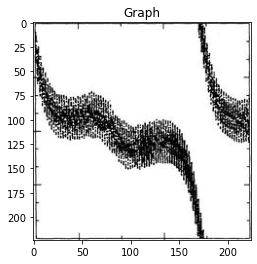

In [35]:
ind = np.random.randint(0,batch_size-1)
plt.imshow(im[ind,:,:,0], cmap='gray')
plt.title(classes[l.numpy()[ind]])
plt.show()

Let's quickly remind ourselves of the breakdown if images in our data:

In [36]:
allImgs = [log for log in glob(classDir_main_to + '/*/*')]
for ic,nc in enumerate(newClasses):
    files = [log for log in glob(nc + '/*')]
    strOut = "{:15} {:5} {}".format(classes[ic], str(len(files)), str( round(len(files)/len(allImgs)*100,2)) + '%')
    print(strOut)

Sun             224   6.71%
Multifig        193   5.79%
RADEC           454   13.61%
Spectra         271   8.12%
RADECrel        130   3.9%
Illustrations   31    0.93%
Graph           180   5.4%
Simulations     92    2.76%
Planets         100   3.0%
SkyNoCoords     1603  48.05%
Photos          58    1.74%


## Making split model

### Build CNN

Get base model for CNN based on requestd net.

Supported as of now includes:
 1. VGG16 with [224,224] images

In [37]:
img_size = [224,224]
net='VGG16'

In [38]:
if 'Xception' in net:
    base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
elif 'VGG16' in net:
    base_model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
elif 'inception_v3' in net:
    base_model = tf.keras.applications.inception_v3.InceptionV3(weights="imagenet", include_top=False)
else:
    print('Yo, no model specified!')
    base_model = []

Build rest of CNN, leaving out last dropout & softmax-classification layer:

In [39]:
tf.keras.backend.clear_session() # clear model

model_cnn = tf.keras.models.Sequential()

# CNN:
# 1. pseudo color
model_cnn.add(tf.keras.layers.BatchNormalization(input_shape=[img_size[0], img_size[0], 1]))

conv1 = tf.keras.layers.Conv2D(filters=10, kernel_size=(1,1), strides=1, padding="SAME", activation="relu", input_shape=[None, None, 1]) # into 10 psedo colors
conv2 = tf.keras.layers.Conv2D(filters=3, kernel_size=(1,1), strides=1, padding="SAME", activation="relu") # down to RGB channels
model_cnn.add(conv1)
model_cnn.add(conv2)

# 2. pre-trained model
model_cnn.add(base_model)

# 3. now the output layers for classification --> might take this off?
#model_cnn.add(tf.keras.layers.GlobalAveragePooling2D()) # this global average pooling is like building "confidence maps"

## HERE PUT IN GLOBAL POOLING MAYBE?
# now the output layers
model_cnn.add(tf.keras.layers.GlobalAveragePooling2D()) # this global average pooling is like building "confidence maps"
model_cnn.add(tf.keras.layers.Dropout(rate=0.5)) # dropout to help with overfitting

# flatten for combo
model_cnn.add(tf.keras.layers.Flatten(input_shape=model_cnn.output.shape))

Now, make sure we don't train the pre-trained network:

In [40]:
# don't train input net:
for layer in model_cnn.layers:
    if (net.lower() == 'vgg16') and ('vgg16' in layer.name.lower()):
        layer.trainable = False
    if (net.lower() == 'inception_v3') and ('inception_v3' in layer.name.lower()):
        layer.trainable = False
    print(layer.name, layer.trainable)

batch_normalization True
conv2d True
conv2d_1 True
vgg16 False
global_average_pooling2d True
dropout True
flatten True


Take a quick look:

In [41]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 10)      20        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 3)       33        
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

### Build 1-hot-ish text classification

Leaving off last layer of classification & dropout:

In [42]:
nNeurons = 10000
nLayers = 5
dropoutRate = 0.5
batchNorm = True

model_text = tf.keras.models.Sequential()
model_text.add(tf.keras.layers.Flatten(input_shape=[len(totalWords),1]))

# 5 layers
for layer in range(nLayers):
    model_text.add(tf.keras.layers.Dropout(rate=dropoutRate))
    if batchNorm:
        model_text.add(tf.keras.layers.BatchNormalization())
    model_text.add(tf.keras.layers.Dense(nNeurons, activation="elu", kernel_initializer="he_normal"))

Check out this model real quick too:

In [43]:
model_text.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 6684)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6684)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6684)              26736     
_________________________________________________________________
dense (Dense)                (None, 10000)             66850000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 10000)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10000)             40000     
_________________________________________________________________
dense_1 (Dense)              (None, 10000)            

### Combine model outputs

Combine the outputs of the models.  Lots of reference from: https://stackoverflow.com/questions/55169593/i-dont-get-the-keras-fit-generator-to-work-with-mixed-image-and-number-input

In [44]:
combinedInput = tf.concat([model_cnn.output, model_text.output],axis=1)

Now we will add dropout & classify:

In [45]:
dropoutRate2 = 0.5
nOutputs = len(classes)
nNeurons2 = 3500
nDense2 = 500
batch_norm2 = True

dropOutLayer = tf.keras.layers.Dropout(rate=dropoutRate2)(combinedInput)
# batch-norm?
#if batch_norm2:
bn1 = tf.keras.layers.BatchNormalization()(dropOutLayer)
#    #do
#else:
#    dropOutLayer = tf.keras.layers.Dropout(rate=dropoutRate2)(combinedInput)
# dense layer... just 1?
dn1 = tf.keras.layers.Dense(nNeurons2, activation="elu", kernel_initializer="he_normal")(bn1)

# more drops
do2 = tf.keras.layers.Dropout(rate=dropoutRate2)(dn1)
#if batch_norm2:
bn2 = tf.keras.layers.BatchNormalization()(do2)
# one more layer
dn2 = tf.keras.layers.Dense(nDense2, activation="elu", kernel_initializer="he_normal")(bn2)

do3 = tf.keras.layers.Dropout(rate=dropoutRate2)(dn2)
bn3 = tf.keras.layers.BatchNormalization()(do3)

classificationLayer = tf.keras.layers.Dense(nOutputs, activation="softmax")(bn3)
#else:
#    classificationLayer = tf.keras.layers.Dense(nOutputs, activation="softmax")(do2)

Now we combine last layers and model into combo-model:

In [46]:
model = tf.keras.Model(inputs=[model_cnn.input, model_text.input], outputs=classificationLayer)

Take a look:

In [47]:
#model.summary()

Or the diagram:

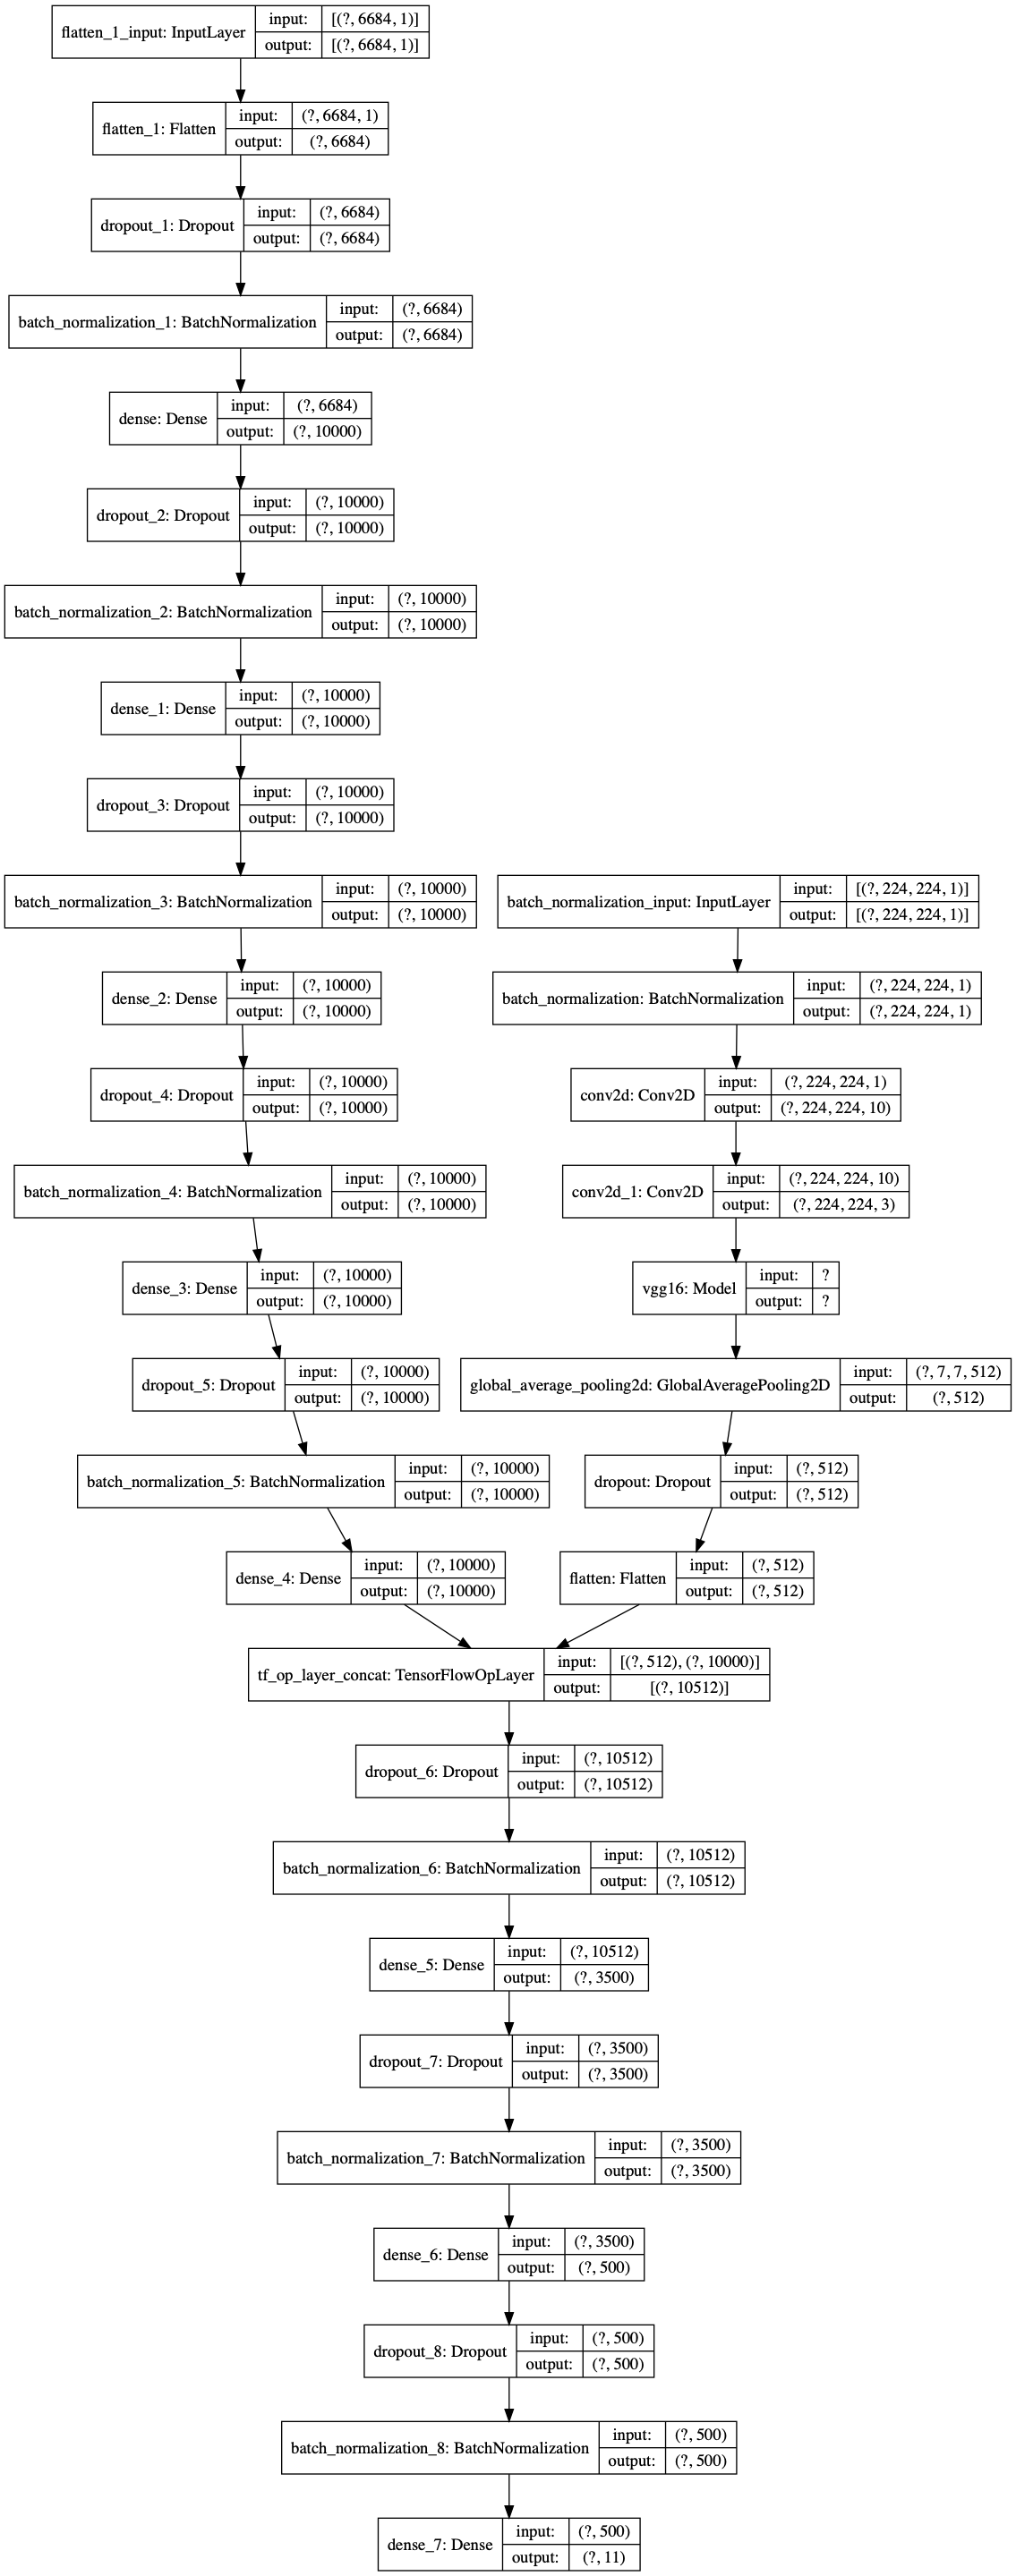

In [48]:
tf.keras.utils.plot_model(model, "my_hybrid_model.png", show_shapes=True, show_layer_names=True, expand_nested=False)

Compile:

In [49]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              metrics=["accuracy"])

Save model & early stopping:

In [50]:
# how many epochs before we roll back to our best model after valid loss has been increasing?
patience_epochs = 10
saveModelFile = modelsDir + "my_keras_model_combinedModel.h5"

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience_epochs,restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(saveModelFile, save_best_only=True)

Fit from generator:

In [52]:
batch_size = 64
#nepochs = 100
nepochs = 1 # quick tester

#history = model.fit_generator(generate_data('train', classDir = classDir_main_to, classes=classes, batch_size=batch_size), 
#                              steps_per_epoch = 75,
#                              epochs=100, 
#                              validation_data=generate_data('valid', classDir = classDir_main_to, classes=classes, batch_size=batch_size), 
#                              validation_steps = 20,
#                              callbacks=[checkpoint_cb, early_stopping_cb])

# for TF 2.+ ?
# history = model.fit(generate_data_old('train', classDir = classDir_main_to, classes=classes, batch_size=batch_size), 
#                               steps_per_epoch = 75,
#                               epochs=100, 
#                               validation_data=generate_data_old('valid', classDir = classDir_main_to, classes=classes, batch_size=batch_size), 
#                               validation_steps = 20,
#                               callbacks=[checkpoint_cb, early_stopping_cb])

history = model.fit_generator(generate_data('train', classDir = classDir_main_to, classes=classes, batch_size=batch_size), 
                              steps_per_epoch = len(X_train_text)//batch_size,
                              epochs=nepochs, 
                              validation_data=generate_data('valid', classDir = classDir_main_to, classes=classes, batch_size=batch_size), 
                              validation_steps = len(X_valid_text)//batch_size,
                              callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
39/39 [==============================] - 2985s 77s/step - loss: 2.4291 - accuracy: 0.3750 - val_loss: 8.2927 - val_accuracy: 0.4107
Epoch 2/100
39/39 [==============================] - 2805s 72s/step - loss: 1.6923 - accuracy: 0.5393 - val_loss: 3.9607 - val_accuracy: 0.3996
Epoch 3/100
39/39 [==============================] - 2804s 72s/step - loss: 1.4758 - accuracy: 0.5813 - val_loss: 3.0041 - val_accuracy: 0.4018
Epoch 4/100
39/39 [==============================] - 2805s 72s/step - loss: 1.3173 - accuracy: 0.6254 - val_loss: 1.8657 - val_accuracy: 0.4888
Epoch 5/100
39/39 [==============================] - 2807s 72s/step - loss: 1.1321 - accuracy: 0.6699 - val_loss: 1.7288 - val_accuracy: 0.6250
Epoch 6/100
39/39 [==============================] - 2802s 72s/step - loss: 1.0498 - accuracy: 0.6911 - val_loss: 1.7497 - val_accuracy: 0.5268
Epoch 7/100
39/39 [==============================] - 2810s 72s/step - loss: 0.9854 - accuracy: 0.7035 - val_loss: 1.4550 - val_accuracy:

KeyboardInterrupt: 

Plot history:

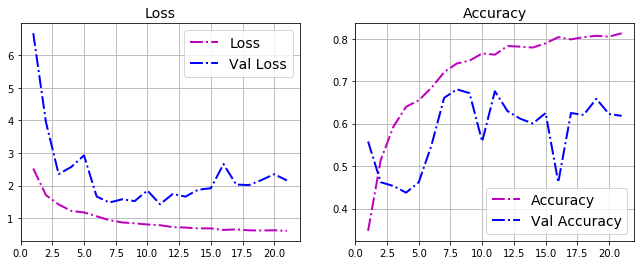

In [52]:
plt.figure(figsize=(11,4))

epcs = np.arange(len(history.history['loss']))+1

plt.subplot(121)
plt.plot(epcs, history.history['loss'], "m-.", linewidth=2, label="Loss")
plt.plot(epcs, history.history['val_loss'], "b-.", linewidth=2, label="Val Loss")
plt.grid(True)
plt.legend(loc="upper right", fontsize=14)
plt.title("Loss", fontsize=14)

plt.subplot(122)
plt.plot(epcs, history.history['accuracy'], "m-.", linewidth=2, label="Accuracy")
plt.plot(epcs, history.history['val_accuracy'], "b-.", linewidth=2, label="Val Accuracy")
plt.grid(True)
plt.legend(loc="lower right", fontsize=14)
plt.title("Accuracy", fontsize=14)

plt.show()

Import saved model: **THIS NEEDS UPDATING MIGHT BE BROKEN FROM HERE AND BELOW**

In [49]:
model.load_weights(saveModelFile)

In [51]:
batch_size = 32
#loss, acc = model.evaluate(generate_data('test', classDir = classDir_main_to, classes=classes, batch_size=batch_size))

In [49]:
print("Model: loss, accuracy: {:5.2f} {:5.2f}%".format(loss, 100*acc))

Model: loss, accuracy:  2.10 58.00%


In [53]:
#y_pred = model.predict_classes(tf.cast(X_test_in,tf.float32))#.astype('float32'))
y_pred = model.predict(generate_data('test', classDir = classDir_main_to, classes=classes, batch_size=batch_size))#.astype('float32'))


TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

Best on the validation:

In [51]:
valid_error = model.evaluate(X_valid_in, y_valid);

226/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

So, about 60 overall%.

Also plot history:

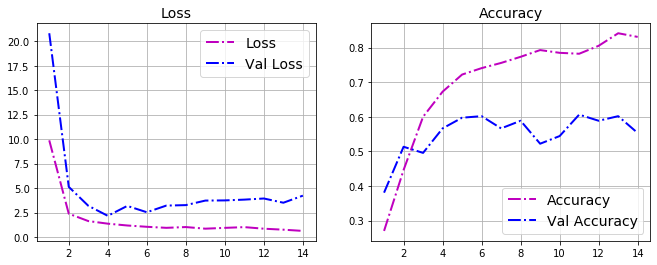

Also print out what we are getting right/wrong by category:

In [53]:
calcper = np.zeros([2,len(classes)])
for n in range(len(y_test)):
    if y_test[n] == y_pred[n]:
        calcper[0, int(y_test[n])] += 1
    calcper[1, int(y_test[n])] += 1

for i, c in enumerate(classes):
    if calcper[1,i].sum() > 0:
        #print(c, round(calcper[0,i].sum()/calcper[1,i].sum(),4)*100, int(calcper[1,i].sum()))
        strOut = "{:15} {:5}% {}".format(c, round(calcper[0,i].sum()/calcper[1,i].sum()*100,2), int(calcper[1,i].sum()))
        print(strOut)
    else:
        print(c, ' ---- no tests')

Sun             81.25% 16
Multifig        26.67% 15
RADEC           66.67% 30
Spectra         63.16% 19
RADECrel         50.0% 12
Illustrations     0.0% 2
Graph           54.55% 11
Simulations      62.5% 8
Planets           0.0% 2
SkyNoCoords     63.33% 30
Photos           40.0% 5
